In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func , inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite" , echo =False)

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_measure_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
#last_measure_date

# Calculate the date 1 year ago from the last data point in the database
last_year_date = dt.datetime.strptime(last_measure_date, "%Y-%m-%d") - dt.timedelta(days=366)
#last_year_date
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year_date).all()
print(query)

[('2016-08-23', 0.0), ('2016-08-24', 0.08), ('2016-08-25', 0.08), ('2016-08-26', 0.0), ('2016-08-27', 0.0), ('2016-08-28', 0.01), ('2016-08-29', 0.0), ('2016-08-30', 0.0), ('2016-08-31', 0.13), ('2016-09-01', 0.0), ('2016-09-02', 0.0), ('2016-09-03', 0.0), ('2016-09-04', 0.03), ('2016-09-05', None), ('2016-09-06', None), ('2016-09-07', 0.05), ('2016-09-08', 0.0), ('2016-09-09', 0.03), ('2016-09-10', 0.0), ('2016-09-11', 0.05), ('2016-09-12', 0.0), ('2016-09-13', 0.02), ('2016-09-14', 1.32), ('2016-09-15', 0.42), ('2016-09-16', 0.06), ('2016-09-17', 0.05), ('2016-09-18', 0.0), ('2016-09-19', 0.0), ('2016-09-20', 0.0), ('2016-09-21', 0.0), ('2016-09-22', 0.02), ('2016-09-23', 0.0), ('2016-09-24', 0.0), ('2016-09-25', 0.0), ('2016-09-26', 0.06), ('2016-09-27', 0.02), ('2016-09-28', 0.0), ('2016-09-29', 0.0), ('2016-09-30', 0.0), ('2016-10-01', 0.0), ('2016-10-02', 0.0), ('2016-10-03', 0.0), ('2016-10-04', 0.0), ('2016-10-05', 0.0), ('2016-10-06', 0.0), ('2016-10-07', 0.0), ('2016-10-08', 

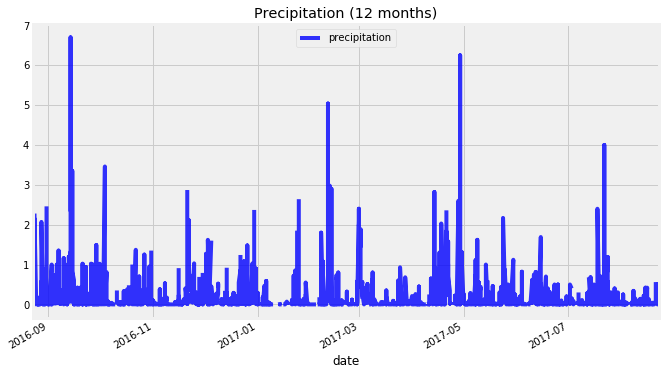

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])

# Change datatype from element to datetime object on Pandas
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], format='%Y-%m-%d')

# Set index to date
precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)

# precipitation_df.head(20)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title="Precipitation (12 months)", color='blue', alpha=0.8, figsize=(10,6))
plt.legend(loc='upper center', prop={'size': 10})
plt.savefig("Images/Precipitation.png")
plt.show()


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(Measurement.station).distinct().count()
print(f"Count: {available_stations} ")


Count: 9 


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station=most_active_stations[0][0]
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

print(f"Low: {most_active_temps[0][0]} High: {most_active_temps[0][1]} Average: {round(most_active_temps[0][2], 1)}")


Low: 54.0 High: 85.0 Average: 71.7


In [19]:
# Choose the station with the highest number of temperature observations.
highest_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
highest_temps_station= highest_temps_station[0]

print(highest_temps_station)

USC00519281


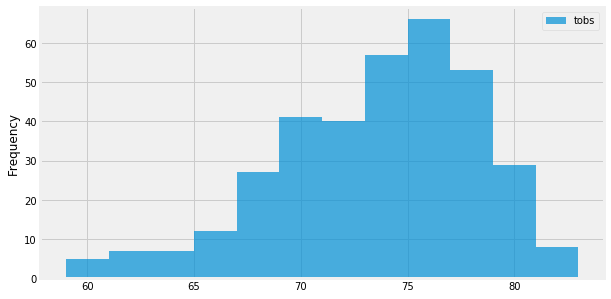

In [20]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observations = session.query( Measurement.tobs).filter(Measurement.date >= last_year_date).\
    filter(Measurement.station == highest_temps_station).all()
temp_observations = pd.DataFrame(temp_observations, columns=['tobs'])
temp_observations.plot.hist(bins=12, alpha=0.7, figsize=(9,5))
plt.style.use('fivethirtyeight')
plt.savefig("Images/TemperaturevsFrequency.png")
plt.show()



In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-02-26', '2016-03-02'))

[(63.0, 70.825, 80.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_data = calc_temps('2015-02-26', '2015-03-02')
trip_data


[(65.0, 71.18181818181819, 78.0)]

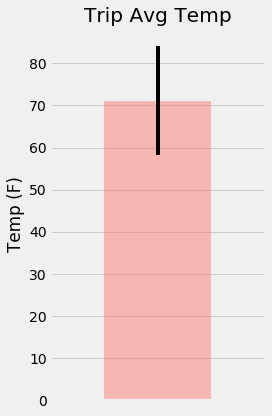

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_data, columns=['tmin', 'tavg', 'tmax'])

trip_df.plot.bar(y='tavg', yerr=(trip_df['tmax'] - trip_df['tmin']), \
                 title='Trip Avg Temp', color='salmon', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp.png")
plt.show()


In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    select_column = [Measurement.station, 
               Station.name, 
               Station.latitude, 
               Station.longitude, 
               Station.elevation, 
               Measurement.prcp]

    return session.query(*select_column).\
                filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).\
filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
print(precipitation('2016-02-26','2016-03-02'))


[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.38), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.36), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.3), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.04), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
#start_date = '2018-01-01'
#end_date ='2018-01-25'

# Use the start and end date to create a range of dates
#dates = session.query(Measurement.date).\
        #filter(Measurement.date >= start_date).\
        #filter(Measurement.date <= end_date).\
       # group_by(Measurement.date).all()

#trip_dates = [d[0] for d in dates]

# Stip off the year and save a list of %m-%d strings

# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
trip_start = '2018-01-01'
trip_end = '2018-01-07'
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end, freq='D')
# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals



# Loop through the list of %m-%d strings and calculate the normals for each date



[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

daily_normals_df= pd.DataFrame(normals,columns=['tmin', 'tavg', 'tmax'])
# Add trip_dates to Pandas DataFrame
daily_normals_df['date']= trip_dates
# Change datatype from element to datetime object on Pandas, makes x axis title to add
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')
daily_normals_df.set_index('date',inplace=True)
daily_normals_df


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


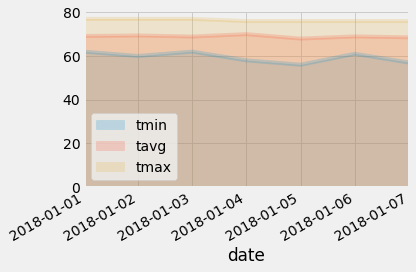

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True,)
plt.tight_layout()
plt.savefig("Images/DailyNormalTemps.png")
plt.show()
